In [1]:
from osgeo import gdal
from math import floor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## A Notebook used to tile an entire SAR image into distinct footprints to pass into the trained model

In [2]:
# Opening the raster
raster = "D:\\ICEEYE\\Proposal_ID_PP0091278\\CS-13801\\SLEA_3279211_180312\\Baker\\SLEA-Repojected-WSG84.tiff"
ds = gdal.Open(raster)

raster_band = ds.GetRasterBand(1)
xoffset, px_w, rot1, yoffset, rot2, px_h = ds.GetGeoTransform() # The transformation matrix to get the coordinates from the picture

icesat_data = "D:\\ICEEYE\\Proposal_ID_PP0091278\\CS-13801\\SLEA_3279211_180312\\Baker\\Coincident Data\\parsed-data-coincident.csv"
icesat_data = pd.read_csv(icesat_data)
num_rows = len(icesat_data)

print("Projection: ", ds.GetProjection()) # get projection
print("Tiff width (pixels):", ds.RasterXSize)  # number of columns
print("Tiff Height (pixels):", ds.RasterYSize)  # number of rows
print("Band count:", ds.RasterCount)  # number of bands
print("GeoTransform Matrix", ds.GetGeoTransform())
print("Statistics:", ds.GetRasterBand(1).GetStatistics(0,1))
print(f"Number of data points: {num_rows}")
print(icesat_data.head(1))

data_array2 = ds.GetRasterBand(1).ReadAsArray() # Indexing for raster bands starts at 1, not 0

# plt.figure(figsize=(10, 10))
# plt.imshow(data_array2, cmap="viridis") # Data array contains elevation data from the raster band. Is this always true?
# plt.colorbar()
# plt.show()

Projection:  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Tiff width (pixels): 45644
Tiff Height (pixels): 12985
Band count: 1
GeoTransform Matrix (-142.01952918536568, 1.5567671032873044e-05, 0.0, 73.49706295700543, 0.0, -1.5567671032873044e-05)
Statistics: [0.0, 52182.0, 839.82720229523, 953.31374383473]
Number of data points: 4685
   Unnamed: 0.1  Unnamed: 0  Beam        Lat         Lon       FBH  \
0        207565      660654  gt2r  73.316875 -141.622595  0.233558   

   FBH Confidence  FBH Quality  FBH Uncertainty  Ground Dist(m)  ...  \
0        0.018878            1         0.010487        9.188391  ...   

                  Calendar Time  Height Likely Obstructed  Ice Concentration  \
0  "04:44:49.290491 2024-01-19"                         1        

In [3]:
# Utility Functions
def getTileCenter(index: int):
    row = icesat_data.iloc[[index]]
    lat = float(row['Lat'])
    lon = float(row['Lon'])
    pixel_x = (lon - xoffset) / px_w
    pixel_x = floor(pixel_x - 8.5)

    pixel_y = (lat - yoffset) / px_h
    pixel_y = floor(pixel_y - 8.5)

    calculatedCoord = (pixel_x, pixel_y)
    return calculatedCoord

def getFileDirectoryAndName(index: int, data_string: str):
    path = "D:\\ICEEYE\\Proposal_ID_PP0091278\\CS-13801\\SLEA_3279211_180312\\Baker\\Coincident Data\\Ice-Sat-Tiles-Scaled-2"
    return path + "\\" + str(index) + "_" + data_string + ".tif"

def isTileEmpty(pixelTuples: tuple):
    topLeftX, topLeftY = pixelTuples
    tile = raster_band.ReadAsArray(topLeftX,topLeftY, 17, 17)
    if tile is not None and tile.any():
        sortList = sorted(tile[0])
        # print([sortList[0], sortList[len(sortList)-1]])
        return True
    return False

def getDataFromRow(row):
    beam = row['Beam']
    ice_height = str(row['Ice Height'])
    snow_height = str(row['Snow Height'])
    # TODO: Calculate the ice thickness and just return that as the datastring
    return "_".join([beam, ice_height, snow_height])

In [4]:
print("Tiff width (pixels):", ds.RasterXSize)  # number of columns
print("Tiff Height (pixels):", ds.RasterYSize)  # number of rows
FOOTPRINT_WIDTH = 17
VISUAL_FACTOR = 10

x_corners = []
y_corners = []

tile_num = 0
y_index = 0
measuredVal = 0
numRepeats = 0
for i, row in icesat_data.iterrows():
    pixelCoords = getTileCenter(i)
    print(f"{i} / {num_rows}")
    if i + 1 < num_rows:
        nextCoords = getTileCenter(i+1)
    else:
        nextCoords = (False, False)
    beam_name = row['Beam']
    data_string = getDataFromRow(row)
    window = (*pixelCoords, 17, 17)
    # If the next point is at the same pixel coordinate, just update the running total
    if pixelCoords == nextCoords:
        raise ("In this case, no tile should have been repeated")
        measuredVal += fb_h
        numRepeats += 1
    else:
        # otherwise, tile the image using the average of the running total's freeboard measurement.
        if numRepeats == 0:
            tileName = getFileDirectoryAndName(i, data_string)
        else:
            raise ("In this case, no tile should have been repeated")
            measuredVal += fb_h
            numRepeats += 1
            tileName = getFileDirectoryAndName(measuredVal / numRepeats, i, beam_name)
        hasData = isTileEmpty(pixelCoords)
        if not hasData:
            print(i, "Has no data", pixelCoords)
        else:
            if i % VISUAL_FACTOR == 0:
                x, y = pixelCoords
                x_corners.append(x)
                y_corners.append(y)
                print(i, " - ", tileName)
            gdal.Translate(tileName, raster, srcWin = window, format="PNG", scaleParams=[[]])
            tile_num += 1
            measuredVal = 0
            numRepeats = 0

Tiff width (pixels): 45644
Tiff Height (pixels): 12985
0 / 4685
0  -  D:\ICEEYE\Proposal_ID_PP0091278\CS-13801\SLEA_3279211_180312\Baker\Coincident Data\Ice-Sat-Tiles-Scaled-3\0_gt2r_0.150153_0.0834047.tif
1 / 4685


C:\Users\John\AppData\Local\Temp\ipykernel_18724\3048266248.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  lat = float(row['Lat'])
C:\Users\John\AppData\Local\Temp\ipykernel_18724\3048266248.py:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  lon = float(row['Lon'])


2 / 4685
3 / 4685
4 / 4685
5 / 4685
6 / 4685
7 / 4685
8 / 4685
9 / 4685
10 / 4685
10  -  D:\ICEEYE\Proposal_ID_PP0091278\CS-13801\SLEA_3279211_180312\Baker\Coincident Data\Ice-Sat-Tiles-Scaled-3\10_gt2r_0.1431693_0.10232268.tif
11 / 4685
12 / 4685
13 / 4685
14 / 4685
15 / 4685
16 / 4685
17 / 4685
18 / 4685
19 / 4685
20 / 4685
20  -  D:\ICEEYE\Proposal_ID_PP0091278\CS-13801\SLEA_3279211_180312\Baker\Coincident Data\Ice-Sat-Tiles-Scaled-3\20_gt2r_0.1569928_0.24956238.tif
21 / 4685
22 / 4685
23 / 4685
24 / 4685
25 / 4685
26 / 4685
27 / 4685
28 / 4685
29 / 4685
30 / 4685
30  -  D:\ICEEYE\Proposal_ID_PP0091278\CS-13801\SLEA_3279211_180312\Baker\Coincident Data\Ice-Sat-Tiles-Scaled-3\30_gt2r_0.160057_0.38407905.tif
31 / 4685
32 / 4685
33 / 4685
34 / 4685
35 / 4685
36 / 4685
37 / 4685
38 / 4685
39 / 4685
40 / 4685
40  -  D:\ICEEYE\Proposal_ID_PP0091278\CS-13801\SLEA_3279211_180312\Baker\Coincident Data\Ice-Sat-Tiles-Scaled-3\40_gt2r_0.3280276_-0.09764087.tif
41 / 4685
42 / 4685
43 / 4685
44 /

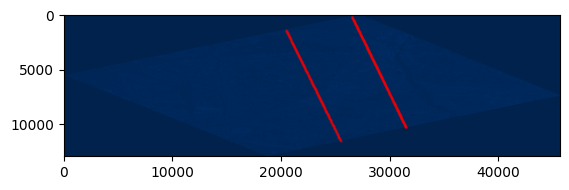

In [16]:
plt.imshow(data_array2, cmap="cividis") # Data array contains elevation data from the raster band. Is this always true?
plt.scatter(x=x_corners, y=y_corners, c='r', s=1, alpha=0.3)
# plt.title(f"SAR Tiling for Trained Model (Factor of {VISUAL_FACTOR})")
# plt.figtext(0.9, 0.25, f'Total of {tile_num} tiles', horizontalalignment='right')
plt.show()